***이미지에 있는 내용을 기반으로 Oracle Database에서 뷰와 트리거를 사용하여 데이터 암호화를 구현하는 과정을 추측해보겠습니다. 여기서 "뷰(View)"와 "트리거(Trigger)"는 데이터 암호화와 복호화 작업을 처리하는 데 사용될 수 있습니다.***

### 암호화 및 복호화의 일반적인 과정

1. **데이터 삽입 시 암호화** : ***TRIGGER***
   - 사용자가 데이터를 테이블에 삽입하면, 트리거가 실행되어 해당 데이터를 암호화합니다.
   - 트리거는 `INSERT` 또는 `UPDATE` 작업 시 호출되며, 데이터를 암호화하는 프로시저를 호출할 수 있습니다.

2. **데이터 조회 시 복호화** : ***VIEW***
   - 사용자가 데이터를 조회할 때, 뷰가 암호화된 데이터를 복호화하여 반환합니다.
   - 뷰는 암호화된 컬럼을 복호화하는 SQL 함수를 포함할 수 있습니다.

### 구체적인 예시

#### 1. 테이블 및 암호화 트리거

예를 들어, `EMP` 테이블에 대한 암호화 트리거를 설정할 수 있습니다.

```sql
CREATE TABLE EMP (
    EMP_ID NUMBER,
    NAME VARCHAR2(100),
    SSN_ENC VARCHAR2(256)
);

CREATE OR REPLACE TRIGGER encrypt_emp_data
BEFORE INSERT OR UPDATE ON EMP
FOR EACH ROW
BEGIN
    :NEW.SSN_ENC := ENCRYPTION_FUNCTION(:NEW.SSN_ENC);
END;
/
```

여기서 `ENCRYPTION_FUNCTION`은 사용자 정의 암호화 함수입니다.

#### 2. 뷰 및 복호화

암호화된 데이터를 복호화하여 사용자에게 보여주기 위해 뷰를 생성합니다.

```sql
CREATE OR REPLACE VIEW EMP_VIEW AS
SELECT EMP_ID,
       NAME,
       DECRYPTION_FUNCTION(SSN_ENC) AS SSN
FROM EMP;
```

여기서 `DECRYPTION_FUNCTION`은 사용자 정의 복호화 함수입니다.

### 이미지의 데이터 분석

이미지의 데이터는 여러 객체와 관련이 있습니다. 예를 들어:

- **COPY_TABLE**, **ENC_TABLE** 등은 데이터 암호화와 관련된 테이블일 수 있습니다.
- **TEMP_TRG**, **PROTECT_DML_TRG** 등은 데이터 삽입, 업데이트 시 암호화 작업을 처리하는 트리거일 수 있습니다.
- **ROOT_VIEW**, **SIT**, **SUT** 등은 암호화된 데이터를 복호화하여 조회할 때 사용하는 뷰일 수 있습니다.

### 종합적인 추측

1. **테이블**: `COPY_TABLE`, `ENC_TABLE`, `ENC_1` 등은 원본 데이터와 암호화된 데이터를 저장하는 테이블일 수 있습니다.
2. **뷰**: `ROOT_VIEW`와 같은 뷰는 암호화된 데이터를 복호화하여 사용자에게 제공할 수 있습니다.
3. **트리거**: `TEMP_TRG`, `PROTECT_DML_TRG`와 같은 트리거는 데이터가 테이블에 삽입되거나 업데이트될 때 자동으로 실행되어 암호화 과정을 수행합니다.

### 결론

이미지에서 제공된 정보와 일반적인 데이터 암호화 및 복호화의 원리를 바탕으로, 뷰와 트리거를 사용하여 Oracle Database에서 데이터 암호화 과정을 구현하는 방법을 추측할 수 있습니다. 구체적인 구현은 오픈소스가 아니므로 정확히 알 수는 없으나, 일반적으로 위에서 설명한 과정과 유사할 가능성이 큽니다.

---

![alt text](image.png)

> **VIEW**에는 `INSERT`, `UPDATE`, `DELETE` 를 쓸 수가 없어서, **TRIGGER**를 이용하여 추가적인 OBJECT를 생성한다. 

> **VIEW**를 사용해서 복호화를 하게되고 **INSTEAD OF TRIGGER**를 이용하여 암호화를 하게 됨으로써 ***기존 쿼리 변경을 최소화*** 할 수 있다.

> 암호화 테이블이 변경될 때 마다 관련 View와 Trigger도 변경해주어야하고 그것이 DCC의 `객체 재생성` (수동으로 재 생성해야 함) - 암호화에 대한 유지관리를 계속해서 해줘야 한다.

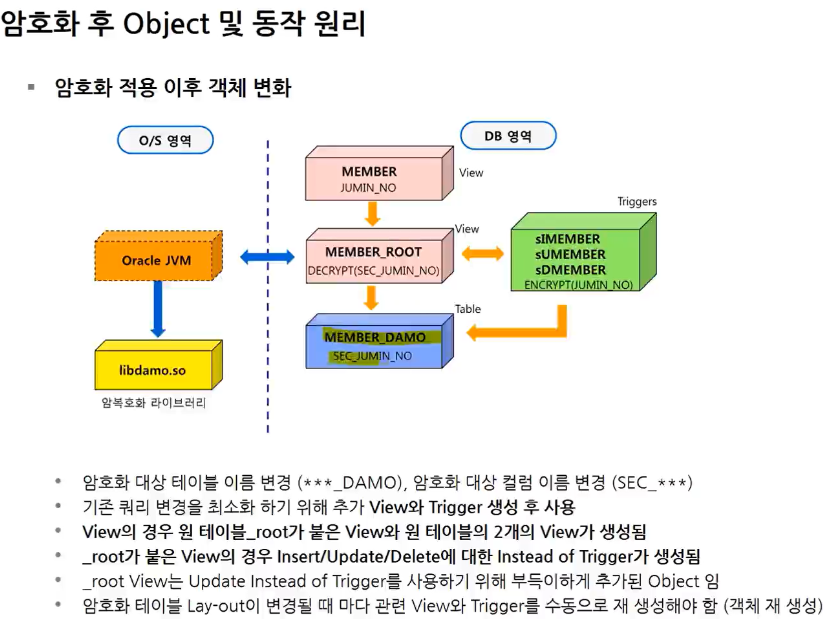

암호화 적용 후에는 VIEW가 2개, TRIGGER가 3개가 생성된다. ( = 암호화관련 OBJECT들이 생성된다.)

'MEMBER_ROOT' VIEW에는 `INSERT`, `UPDATE`, `DELETE`에 대한 Instead of Trigger가 생성됨. 그래서 실제로 'MEMBER_ROOT' VIEW가 암/복호화(ENC,DEC)를 수행한다고 보면 된다.

'MEMBER_ROOT' VIEW는 Update Instead of Trigger를 사용하기 위해 부득이하게 추가된 Object 임

### #쿼리최적화

### 쿼리최적화는 VEIW와 TRIGGER를 쓰지않고 직접 암호화 테이블에 접근해서 암호화 된 값을 컨트롤, 수정 등을 하는 것. 

#### 암호화 적용시 암호화 쿼리 최적화 대상

**1. 불필요한 암호화 및 복호화 방지**
  - 실제 암호화 값에 대한 복호화값이 쿼리 실행 도중 일시적으로만 사용되거나, 단순 비교만을 위해 사용되는 경우. (복호화하지 않고도 가능한 경우)
    - 서브 쿼리에서 암호화 컬럼에 대한 참조가 대량으로 참조하는 경우
    - 암호화 컬럼 간 조인
    - 암호화 데이터 간의 복제
    - 암호화 컬럼이 GROUP / HAVING 구문이 포함된 쿼리

**2. VIEW 제약**
  - 사용자는 테이블을 직접 사용하다가 VTI로 암호화시 뷰를 통해 테이블을 사용하도록 변경이 되게 되는데, 이로 인해 암호화 되기 이전에 테이블에 쓰이던 정상적인 쿼리들이 암호화 후
  뷰로 변경되면서 error가 발생하게 된다. 대표적으로 `merge into`, `return rowid` 같은 것들이 대표적. 뷰에 적용하는 것이 불가능. > 해당 쿼리를 암호화 최적화하여 뷰가 아닌 암호화 테이블을 직접 사용할 수 있게 수정해주어야한다.

**3. 실행 계획 변경**
  - 암호화 적용 후에는 기존 쿼리들은 view를 이용하게 되고, 암호화 컬럼에 대한 인덱스가 변경되므로 실행계획이 변경될 수 있음. 실행계획이 비효율적으로 변경되는 경우, VIEW대신 TABLE을 직접 이용하도록 변경함으로써 Plan을 개선할 수 있음.
    - 암호화 컬럼을 이용한 조인
    - 복잡한 쿼리
    - 전방 일치 검색
    - HINT가 들어있는 쿼리
    - DB link와 연관 쿼리

**4. 기존 테이블에 적용되어 있던 trigger**
  - 기존 TABLE에 적용되어 있던 TRIGGER의 구문은 새로 추가된 VIEW와 TRIGGER의 영향으로 오동작하거나, 결과가 달라질 수 있어 VIEW 대신에 암호화 테이블을 참조하도록 수정하는 것이 필요함.

**5. DML**
  - `INSERT`, `UPDATE` 구문의 경우 암호화 후에는 VIEW의 TRIGGER를 이용하게 되며 실행 시에 암호화 부하와 더불어 TRIGGER사용에 따른 부하가 추가됨. 즉, TRIGGER를 이용하지 않도록 수정함으로써 성능을 향상시킬 수 있음.

• 암호화 대상 테이블 이름 변경 ( TABLE_DAMO), 암호화 대상 컬럼 이름 변경 (SEC_COLUMN )

• 기존 쿼리 변경을 최소화 하기 위해 추가 View와 Trigger 생성 후 사용

• View의 경우 원 테이블_root가 붙은 View와 원 테이블의 2개의 View가 생성됨

• 

• 